# Comparing gene expression quantification strategies

## Introduction

You've run STAR to align and create a Sequence Alignment Map (SAM) file, `samtools` to sort and index the SAM file and turn it into a binary SAM file (BAM), `featureCounts` to count the number of reads of features, and `kallisto` to perform all of the above using quasi-alignment and quantification.

The purpose of this homework is to compare the gene expression quantification strategies (we'll call them *"Align-Count"* and *"Quasialign-Count"*)

## Reading list

- [What the FPKM](https://haroldpimentel.wordpress.com/2014/05/08/what-the-fpkm-a-review-rna-seq-expression-units/) - Explain difference between TPM/FPKM/FPKM units
- [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) - linear correlation unit
- [Spearman correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) - rank-based non-linear correlation unit


### Description of libraries in Python

We'll be using five additional libraries in Python:

1. [`numpy`](http://www.numpy.org/) - (pronounced "num-pie") which is basis for most scientific packages. It's basically a nice-looking Python interface to C code. It's very fast.
2. [`pandas`](http://pandas.pydata.org) - This is the "DataFrames in Python." (like R's nice dataframes) They're a super convenient form that's based on `numpy` so they're fast. And you can do convenient things like calculate mea n and variance very easily.
3. [`matplotlib`](http://matplotlib.org/) - This is the base plotting library in Python.
4. [`scipy`](http://www.scipy.org/) - (pronounced "sigh-pie") Contains 
5. [`seaborn`](http://web.stanford.edu/~mwaskom/software/seaborn/index.html) - Statistical plotting library. To be completely honest, R's plotting and graphics capabilities are much better than Python's. However, Python is a really nice langauge to learn and use, it's very memory efficient, can be parallized well, and has a very robust machine learning library, `scikit-learn`, which has a very nice and consistent interface. So this is Python's answer to `ggplot2` (very popular R library for plotting) to try and make plotting in Python nicer looking and to make statistical plots easier to do.

In [1]:
# We're doing "import superlongname as abbrev" for our laziness - this way we don't have to type out the whole thing each time.

# Numerical python library (pronounced "num-pie")
import numpy as np

# Dataframes in Python
import pandas as pd

# Python plotting library
import matplotlib.pyplot as plt

# Statistical plotting library we'll use
import seaborn as sns

sns.set(style='ticks', context='notebook')

# This is necessary to show the plotted figures inside the notebook -- "inline" with the notebook cells
%matplotlib inline

/home/ucsd-train21/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Change directories to where we have our processed data

In [9]:
cd ~/projects/shalek2013/processed_data

/oasis/tscc/scratch/ucsd-train21/shalek2013/processed_data


Read the S10 sample kallisto file. The `index_col="target_id"` tells us that column named "target_id" should be used as the "index" aka the row names. The `head()` command helps us look at the top of the dataframe and shows the first 5 rows by default.

In [3]:
s10_kallisto = pd.read_table('S10_kallisto/abundance.tsv', index_col='target_id')
s10_kallisto.head()

,length,eff_length,est_counts,tpm
target_id,,,,
ENSMUST00000070533.4|ENSMUSG00000051951.5|OTTMUSG00000026353.2|OTTMUST00000065166.1|Xkr4-001|Xkr4|3634|UTR5:1-150|CDS:151-2094|UTR3:2095-3634|,3634,3389.58,0,0
ENSMUST00000194992.5|ENSMUSG00000025900.10|OTTMUSG00000049985.2|OTTMUST00000127194.1|Rp1-002|Rp1|3047|UTR5:1-54|CDS:55-912|UTR3:913-3047|,3047,2802.58,0,0
ENSMUST00000027032.5|ENSMUSG00000025900.10|OTTMUSG00000049985.2|OTTMUST00000127195.2|Rp1-001|Rp1|6869|UTR5:1-127|CDS:128-6415|UTR3:6416-6869|,6869,6624.58,0,0
ENSMUST00000027035.9|ENSMUSG00000025902.13|OTTMUSG00000050014.7|OTTMUST00000127245.2|Sox17-001|Sox17|3127|UTR5:1-1082|CDS:1083-2342|UTR3:2343-3127|,3127,2882.58,0,0
ENSMUST00000195555.1|ENSMUSG00000025902.13|OTTMUSG00000050014.7|OTTMUST00000127249.1|Sox17-005|Sox17|1977|UTR5:1-635|CDS:636-1511|UTR3:1512-1977|,1977,1732.58,0,0


You can also use "`tail`" to show the last few rows: (also 5 by default)

In [4]:
s10_kallisto.tail()

,length,eff_length,est_counts,tpm
target_id,,,,
ENSMUST00000084013.1|ENSMUSG00000065947.3|-|-|mt-Nd4l-201|mt-Nd4l|297|CDS:1-297|,297,70.8467,2438,1204.930
ENSMUST00000082414.1|ENSMUSG00000064363.1|-|-|mt-Nd4-201|mt-Nd4|1378|CDS:1-1378|,1378,1133.5800,43114,1331.720
ENSMUST00000082418.1|ENSMUSG00000064367.1|-|-|mt-Nd5-201|mt-Nd5|1824|CDS:1-1824|,1824,1579.5800,44220,980.222
ENSMUST00000082419.1|ENSMUSG00000064368.1|-|-|mt-Nd6-201|mt-Nd6|519|CDS:1-519|,519,274.6980,4520,576.142
ENSMUST00000082421.1|ENSMUSG00000064370.1|-|-|mt-Cytb-201|mt-Cytb|1144|CDS:1-1144|,1144,899.5790,120234,4679.880


### Exercise 1: using `.head()`

Show the first 17 rows of `s10_kallisto`.

In [5]:
s10_kallisto = pd.read_table('S10_kallisto/abundance.tsv', index_col='target_id')
s10_kallisto.head(17)

,length,eff_length,est_counts,tpm
target_id,,,,
ENSMUST00000070533.4|ENSMUSG00000051951.5|OTTMUSG00000026353.2|OTTMUST00000065166.1|Xkr4-001|Xkr4|3634|UTR5:1-150|CDS:151-2094|UTR3:2095-3634|,3634,3389.580,0.00000,0.000000
ENSMUST00000194992.5|ENSMUSG00000025900.10|OTTMUSG00000049985.2|OTTMUST00000127194.1|Rp1-002|Rp1|3047|UTR5:1-54|CDS:55-912|UTR3:913-3047|,3047,2802.580,0.00000,0.000000
ENSMUST00000027032.5|ENSMUSG00000025900.10|OTTMUSG00000049985.2|OTTMUST00000127195.2|Rp1-001|Rp1|6869|UTR5:1-127|CDS:128-6415|UTR3:6416-6869|,6869,6624.580,0.00000,0.000000
ENSMUST00000027035.9|ENSMUSG00000025902.13|OTTMUSG00000050014.7|OTTMUST00000127245.2|Sox17-001|Sox17|3127|UTR5:1-1082|CDS:1083-2342|UTR3:2343-3127|,3127,2882.580,0.00000,0.000000
ENSMUST00000195555.1|ENSMUSG00000025902.13|OTTMUSG00000050014.7|OTTMUST00000127249.1|Sox17-005|Sox17|1977|UTR5:1-635|CDS:636-1511|UTR3:1512-1977|,1977,1732.580,0.00000,0.000000
ENSMUST00000192650.5|ENSMUSG00000025902.13|OTTMUSG00000050014.7|OTTMUST00000127247.2|Sox17-004|Sox17|3242|UTR5:1-1851|CDS:1852-2916|UTR3:2917-3242|,3242,2997.580,0.00000,0.000000
ENSMUST00000116652.7|ENSMUSG00000025902.13|OTTMUSG00000050014.7|OTTMUST00000127246.1|Sox17-002|Sox17|1512|UTR5:1-249|CDS:250-1509|UTR3:1510-1512|,1512,1267.580,0.00000,0.000000
ENSMUST00000191647.1|ENSMUSG00000025902.13|OTTMUSG00000050014.7|OTTMUST00000127267.2|Sox17-007|Sox17|406|UTR5:1-83|CDS:84-406|,406,163.270,0.00000,0.000000
ENSMUST00000191939.1|ENSMUSG00000025902.13|OTTMUSG00000050014.7|OTTMUST00000127266.2|Sox17-006|Sox17|840|UTR5:1-329|CDS:330-840|,840,595.579,0.00000,0.000000


In [6]:
# "_" is the previous output

assert _.index.shape == (17,)

We can see the number of rows and columns using `.shape`, which shows (nrows, ncols):

In [7]:
s10_kallisto = pd.read_table('S10_kallisto/abundance.tsv', index_col='target_id')
s10_kallisto.shape

(56504, 4)

This seems like a ton of genes, but don't worry, we'll filter on this.

Read the S13 sample kallisto file.

In [11]:
s13_kallisto = pd.read_table('S13_kallisto/abundance.tsv', index_col='target_id')
s13_kallisto.head()

,length,eff_length,est_counts,tpm
target_id,,,,
ENSMUST00000070533.4|ENSMUSG00000051951.5|OTTMUSG00000026353.2|OTTMUST00000065166.1|Xkr4-001|Xkr4|3634|UTR5:1-150|CDS:151-2094|UTR3:2095-3634|,3634,3395.24,2,0.03967
ENSMUST00000194992.5|ENSMUSG00000025900.10|OTTMUSG00000049985.2|OTTMUST00000127194.1|Rp1-002|Rp1|3047|UTR5:1-54|CDS:55-912|UTR3:913-3047|,3047,2808.24,0,0.00000
ENSMUST00000027032.5|ENSMUSG00000025900.10|OTTMUSG00000049985.2|OTTMUST00000127195.2|Rp1-001|Rp1|6869|UTR5:1-127|CDS:128-6415|UTR3:6416-6869|,6869,6630.24,0,0.00000
ENSMUST00000027035.9|ENSMUSG00000025902.13|OTTMUSG00000050014.7|OTTMUST00000127245.2|Sox17-001|Sox17|3127|UTR5:1-1082|CDS:1083-2342|UTR3:2343-3127|,3127,2888.24,0,0.00000
ENSMUST00000195555.1|ENSMUSG00000025902.13|OTTMUSG00000050014.7|OTTMUST00000127249.1|Sox17-005|Sox17|1977|UTR5:1-635|CDS:636-1511|UTR3:1512-1977|,1977,1738.24,0,0.00000


### Exercise 2: How many rows and columns are in s13_kallisto?

Use `shape` to show how many rows and columns are in `s13_kallisto`

In [12]:
s13_kallisto = pd.read_table('S13_kallisto/abundance.tsv', index_col='target_id')
s13_kallisto.shape

(56504, 4)

In [13]:
# "_" is the previous output

assert _ == (56504, 4)

Let's plot their correlation to each other using `jointplot` in seaborn:

/home/ucsd-train21/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


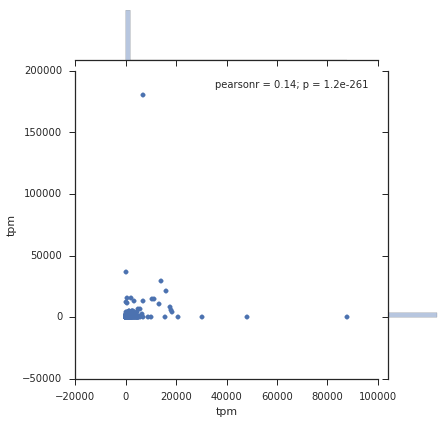

In [14]:
sns.jointplot(s10_kallisto['tpm'], s13_kallisto['tpm'])

Oh right -- we have expression data and the scales are enormous... Notice the 200,000 maximum on the y-scale.  
  
Let's add 1 to all values and take the log2 of the data. We add one because log(0) is undefined and then all our logged values start from zero too. This  
"$\log_2(TPM + 1)$"  
is a very common transformation of expression data so it's easier to analyze.  
  
To do that, we'll create a new column in each of the `s10_kallisto` and `s13_kallisto` dataframes using the existing data. Here's an example of doing something similar but adding 1000.

In [ ]:
s10_kallisto['log2_tpm1000'] = np.log2(s10_kallisto['tpm']+10000)
s10_kallisto.head()

### Exercise 3: Add a log2_tpm column to `s13_kallisto`

In [ ]:
# YOUR CODE HERE

s13_kallisto.head()

In [ ]:
gene_id = 'ENSMUST00000070533.4|ENSMUSG00000051951.5|OTTMUSG00000026353.2|OTTMUST00000065166.1|Xkr4-001|Xkr4|3634|UTR5:1-150|CDS:151-2094|UTR3:2095-3634|'

assert s13_kallisto.loc[gene_id, 'log2_tpm'] == 0.056126371311968043

### Exercise 4: Plot the logged TPM correlation

Use `sns.jointplot` to plot the correlation between the logged TPMs we just made.

In [ ]:
# YOUR CODE HERE

In [ ]:
assert isinstance(_, sns.axisgrid.JointGrid)

Interesting, we have quite a bit of correlation! What if we used rank-based, non-linear correlation such as spearman? We can specify a different statistical function with `stat_func=` and specifying `spearmanr` from `scipy.stats`.

In [ ]:
from scipy.stats import spearmanr

sns.jointplot(s10_kallisto['log2_tpm'], s13_kallisto['log2_tpm'], stat_func=spearmanr)

We'll now create a dataframe containing the two columns ("Series") of the separate `s10_kallisto` and `s13_kallisto` columns, using `pd.concat` to concatenate the two series, and rename them so the names are `s13` and `s10`, using the `keys=['s10', 's13']`. The `axis=1` means to glue along the columns (axis=0 is rows, axis=1 is columns), so that we stack horizontally, versus vertically. Otherwise we'd get a really tall series that can't tell the difference between s10 and s13.

In [ ]:
kallisto_log2_tpm = pd.concat([s10_kallisto['log2_tpm'], s13_kallisto['log2_tpm']], axis=1, keys=['s10', 's13'])
kallisto_log2_tpm.head()

So we have a ton of genes where the expression is near zero. This is not that helpful so let's only use genes with expression greater than one in at least one sample. We'll do this using the [boolean](https://en.wikipedia.org/wiki/Boolean) (True/False) matrix we get from asking "`kallisto_log2_tpm > 1`":

In [ ]:
kallisto_log2_tpm > 1

If we use the convenient `.sum()` function on the dataframe, we'll get the number of "expressed genes" (defining "Expressed genes" as genes with log2(TPM+1) greater than 1) per sample:

In [ ]:
(kallisto_log2_tpm > 1).sum()

If we sum with `axis=1`, then we get the number of samples with expression greater than one for each gene.

In [ ]:
(kallisto_log2_tpm > 1).sum(axis=1)

We can now use this to get all genes expressed in *at least one* sample with "`>= 1`"

In [ ]:
(kallisto_log2_tpm > 1).sum(axis=1) >= 1

Now we can use  the `.loc[]` notation to get the rows we want as a subset. Notice that this outputs the dataframe itself - we haven't assigned it to anything. This is equivalent to extracting your RNA and throwing it on the ground. You can look at it but you didn't put it anywhere useful so you can't do anything with it.

In [ ]:
expressed_genes = (kallisto_log2_tpm > 1).sum(axis=1) >= 1
kallisto_log2_tpm.loc[expressed_genes]

Now let's actually make another dataframe with only the expressed genes.

In [ ]:
kallisto_log2_tpm_expressed = kallisto_log2_tpm.loc[expressed_genes]
print(kallisto_log2_tpm_expressed.shape)
kallisto_log2_tpm_expressed.head()

We'll plot the `jointplot` again, using a little different syntax. Since the data we want are two columns in the same dataframe, we can specify the names of the columns as "x" (first position) and "y" (second position) and then the dataframe in the third position.

In [ ]:
sns.jointplot('s10', 's13', kallisto_log2_tpm_expressed)

### Exercise 5: Plot logged TPM of expressed genes using `spearmanr` as the statistical function

In [ ]:
# YOUR CODE HERE

In [ ]:
assert _.ax_joint.legend_.texts[0].get_text() == 'spearmanr = -0.23; p = 7e-113'

## Reading `featureCounts`

In [ ]:
s10_featurecounts = pd.read_table('s10_featureCounts.txt')
print(s10_featurecounts.shape)
s10_featurecounts.head()

### Exercise 6: Read `s10_featurecounts` table

1. Skip the first row
2. Set the first column (0th column) as the index

In [ ]:
# YOUR CODE HERE
print(s10_featurecounts.shape)
s10_featurecounts.head()

In [ ]:
assert s10_featurecounts.shape == (46983, 6)
assert (s10_featurecounts.columns[:-1] == pd.Index(['Chr', 'Start', 'End', 'Strand', 'Length'],
      dtype='object')).all()

### Calculate TPM from the reads counted by `featureCounts`

Now, `featureCounts` outputs the actual number of reads mapped to each gene. You can tell because the datatype is integer, which would only be true if it was raw read counts, and not a transformed value like TPM, which has decimals (i.e. is a "floating-point" type)


To get the transcripts per kilobase mapped (TPM) so we can compare to the `kallisto` output, we'll have to do some extra steps.

In [ ]:
s10_featurecounts.dtypes

Let's look at the distribution of the number of reads per feature using `sns.distplot`.

In [ ]:
sns.distplot(s10_featurecounts['/home/ucsd-train01/projects/shalek2013/processed_data/S10.Aligned.out.sorted.bam'])

For the next exercise ... remember that you can use convenient methods of ".sum()" to get the sum of a column. This sums all the gene lengths in the data.

In [ ]:
s10_featurecounts['Length'].sum()

Like with the log2 TPM, we'll create a new column based on the existing columns. This example assigns the big ole column name to a single variable so it's easier to work with, and creates a new column that's the sum of all lengths times the number of reads, divided by 2000 (2e3 = $2\times 10^3$).

Notice that you can use regular multiplication with "`*`" and division with "`/`" (addition with "`+`" and "`-`" also work)

In [ ]:
reads = s10_featurecounts['/home/ucsd-train01/projects/shalek2013/processed_data/S10.Aligned.out.sorted.bam']

s10_featurecounts['new_column'] = (s10_featurecounts['Length'].sum() * reads)/2e3
s10_featurecounts.head()

### Exercise 7: Calculate FPKM

Using your knowledge about [FPKM](https://haroldpimentel.wordpress.com/2014/05/08/what-the-fpkm-a-review-rna-seq-expression-units/), add a column called `'fpkm'` to `s10_featurecounts` that's the fragments per kilobase mapped. We're doing FPKM first because you can calculate the TPM from the FPKM easily.

(Use the "Length" column provided rather than the "effective length" which is the length minus the read lengths. otherwise we'll get negative FPKMs!)

In [ ]:
reads = s10_featurecounts['/home/ucsd-train01/projects/shalek2013/processed_data/S10.Aligned.out.sorted.bam']

# YOUR CODE HERE

s10_featurecounts.head()

In [ ]:
assert s10_featurecounts.loc['ENSMUSG00000064842.1', 'fpkm'] == 151.9538381109796

Let's look at the new distribution of the FPKMs. Notice that the range is much smaller than the reads.

In [ ]:
sns.distplot(s10_featurecounts['fpkm'])

### Exercise 8: Calculate TPM

Now add a column called `'tpm'` which uses FPKM to calculate the transcripts per million. You'll need to read the ["What the FPKM"](https://haroldpimentel.wordpress.com/2014/05/08/what-the-fpkm-a-review-rna-seq-expression-units/) blog post in detail to get the equation for TPM.

Hint: How would you sum all the FPKMs in the data?

In [ ]:
# YOUR CODE HERE
s10_featurecounts.head()

In [ ]:
assert s10_featurecounts.loc['ENSMUSG00000064842.1', 'tpm'] == 260.82736102245372

Let's look at this new distribution of TPM. Notice its range is also smaller than the FPKMs.

In [ ]:
sns.distplot(s10_featurecounts['tpm'])

If you plot FPKM vs TPM, you'll see that they're linearly related, just like the equation told us :)

In [ ]:
sns.jointplot('fpkm', 'tpm', s10_featurecounts)

### Exercise 9: Add a log2_tpm column

Add a column called `'log2_tpm'` where you do the log2(TPM+1) transformation that we did before.

In [ ]:
# YOUR CODE HERE
s10_featurecounts.head()

In [ ]:
assert s10_featurecounts.loc['ENSMUSG00000064842.1', 'log2_tpm'] == 8.0324720569159176

## Compare kallisto and featureCounts

Remember this kallisto dataframe we made? Let's take a look at it again.

In [ ]:
kallisto_log2_tpm_expressed.head()

Notice that its row names ("`index`") have all this stuff in them. We really only need the gene ids - everything else is an annotation of the transcript (the length, where the UTR is in the sequence, where the coding region is in the sequence, etc). 

Here's an example of using `split()` on this string which is one of the IDs.

In [ ]:
s = 'ENSMUST00000146665.2|ENSMUSG00000033845.13|OTTMUSG00000029329.3|OTTMUST00000072662.2|Mrpl15-004|Mrpl15|1569|UTR5:1-62|CDS:63-569|UTR3:570-1569|'
s.split('|')

Now since we're using DataFrames we can use this really convenient function `map` which applies the same function to each element of the vector. We'll only get the gene names by "mapping" a small function ("lambda") that splits each item in the row name on the pipe ("|") and takes the 1th item (remember we start counting from 0).

In [ ]:
kallisto_log2_tpm_expressed.index.map(lambda x: x.split('|')[1])

We'll now copy the original dataframe and replace the "`index`" with this new one, so we can compare to `featureCounts`.

In [ ]:
kallisto_log2_tpm_expressed_genes = kallisto_log2_tpm_expressed.copy()
kallisto_log2_tpm_expressed_genes.index = kallisto_log2_tpm_expressed.index.map(lambda x: x.split('|')[1])
print(kallisto_log2_tpm_expressed_genes.shape)
kallisto_log2_tpm_expressed_genes.head()

Notice that we have some duplicate gene ids. This is because there were multiple transcripts per gene id.

This next bit of code takes each gene ID, and for the ones that match, it'll sum the TPMs. This is legal to do because the total number of transcripts has not changed, we're merely summing per gene.

The [`.groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html) function is ***very*** useful every time you have one or more tables that have some common key (in this case gene ids) that you want to use. We won't go into it here but it may come in handy to you later.

In [ ]:
kallisto_log2_tpm_expressed_genes_summed = kallisto_log2_tpm_expressed_genes.groupby(level=0, axis=0).sum()
print(kallisto_log2_tpm_expressed_genes_summed.shape)
kallisto_log2_tpm_expressed_genes_summed.head()

Now we'll use a convenient function called `align` which will unify the row names of the two columns (Series) we have: the kallisto log2 TPMs and the featurecounts log2 TPMs. We'll assign them to "`x`" and "`y`" for short (for now)

In [ ]:
x = kallisto_log2_tpm_expressed_genes_summed['s10']
y = s10_featurecounts['log2_tpm']
print('before aligning:', x.shape, y.shape)

x, y = x.align(y)
print('after aligning:', x.shape, y.shape)
x.head()

So that the plot shows the name of the sample and the algorithm, we'll change the `.name` attribute of the series.

In [ ]:
x.name = 'S10 kallisto'
y.name = 'S10 featureCounts'

In [ ]:
sns.jointplot(x, y)

What about using spearman correlation?

In [ ]:
sns.jointplot(x, y, stat_func=spearmanr)

### Exercise 10: Why did kallisto and featureCounts give different results?

Write 3-5 sentences describing why you think kallisto and FeatureCounts have similar, but different results, based on the algorithms used for mapping and (quasi-)alignment. Recall that with kallisto we mapped to protein-coding transcripts, and for FeatureCounts we first had to map with STAR (which has its own biases - like what?) and only after that we used the basic annotation, both from [GENCODE Mouse V8](http://www.gencodegenes.org/mouse_releases/8.html).

In [ ]:
# YOUR CODE HERE

## Differential expression

We'll now do some differential expression analyses to get a sense of how these different algorithms affect the results.

In [ ]:
kallisto_diff = kallisto_log2_tpm_expressed_genes_summed['s10'] - kallisto_log2_tpm_expressed_genes_summed['s13']
kallisto_diff.head()

In [ ]:
sns.distplot(kallisto_diff)

Since the differences between genes is approximately normal, we can find the genes that are overexpressed in S10 (i.e. speceific to S10) by getting the ones that are 2 standard deviations greater than the mean.

We need this line:

    kallisto_s10_specific_genes = pd.Series(kallisto_s10_specific.index[kallisto_s10_specific])
    
Becaus we want to create a new series where the values are the gene ids, rather than the index is the gene ids. This makes writing to a file easier.

In [ ]:
kallisto_s10_specific = kallisto_diff > (kallisto_diff.mean() + 2*kallisto_diff.std())
kallisto_s10_specific_genes = pd.Series(kallisto_s10_specific.index[kallisto_s10_specific])
print(kallisto_s10_specific_genes.shape)
kallisto_s10_specific_genes.head()

### Exercise 11: Get S13-specific genes in kallisto

Make a series called `kallisto_s13_specific_genes` which contains the genes that are specifically expressed in the sample S13.

(Hint: specific to S13 means underexpressed in S10 - so similar to above, but 2 standard deviations *less than* the mean)

In [ ]:
# YOUR CODE HERE

print(kallisto_s13_specific_genes.shape)
kallisto_s13_specific_genes.head()


In [ ]:
assert kallisto_s13_specific_genes.shape == (162,)

## Save the data and perform an enrichment analysis

We'll do a quick Gene Ontology to get a sense of the kind of genes which are over- or under-enriched. To do this, we'll need to save our genes to a file and then copy that to our computer.

The gene ids we have are the GENCODE ids which are the ENSEMBL ids + '.version', e.g. "ENSMUSG00000000386.14" is ensembl ID ENSMUSG00000000386, version 14. Most of the gene ontology programs recognize the ENSEMBL ids but not GENCODE ids, so we'll remove the stuff after the period using `.split('.')[0]`, which splits the string up every time it sees a period, and then takes the first (0th - counting from zero) item.

In [ ]:
kallisto_s10_specific_genes_ensembl = kallisto_s10_specific_genes.map(lambda x: x.split('.')[0])
kallisto_s13_specific_genes_ensembl = kallisto_s13_specific_genes.map(lambda x: x.split('.')[0])
kallisto_s13_specific_genes_ensembl.head()

We'll save the gene ids, but not the index/row names (which are integers starting from 0 and are boring)

In [ ]:
kallisto_s10_specific_genes_ensembl.to_csv('kallisto_s10_specific_genes.csv', index=False)
kallisto_s13_specific_genes_ensembl.to_csv('kallisto_s13_specific_genes.csv', index=False)

We can look at the data we created with `head`:

In [ ]:
! head kallisto*specific_genes.csv

### Exercise 12: Perform Gene Ontology (GO) enrichment

Use `scp`(Mac/Linus)/`pscp` (Windows) to secure copy these files to your computer.

Go to the [gene ontology website](http://geneontology.org/page/go-enrichment-analysis) (or your other favorite gene ontology enrichment resource) and get the ontology enrichment of the s10-specific and s13-specific genes. What are the two samples enriched for?

Hint: Which organism are we using?

In [ ]:
# YOUR CODE HERE

### Exercise 13: Read S13 featureCounts and do all the transformations we've done


1. Read in the `s13_featureCounts.txt` file
2. Calculate ... ("columnname")
    1. FPKM ("fpkm")
    2. TPM ("tpm")
    3. log2(TPM+1) ("log2_tpm")


In [ ]:
# YOUR CODE HERE
print(s13_featurecounts.shape)
s13_featurecounts.head()

In [ ]:
assert len(s13_featurecounts.columns.intersection(['fpkm', 'tpm', 'log2_tpm'])) == 3
assert s13_featurecounts.loc['ENSMUSG00000064370.1', 'log2_tpm'] == 13.15202328657807

Let's compare these two samples now.

In [ ]:
sns.jointplot(s10_featurecounts['log2_tpm'], s13_featurecounts['log2_tpm'])

### Exercise 14: Get the difference in gene expression

Create a series called `featurecounts_diff` that is the difference between S10 and S13 log2 TPM in featurecounts (relative to S10).

In [ ]:
# YOUR CODE HERE
print(featurecounts_diff.shape)
featurecounts_diff.head()

In [ ]:
assert featurecounts_diff['ENSMUSG00000064842.1'] == 8.0324720569159282

Let's look at the distribution of the differences.

In [ ]:
sns.distplot(featurecounts_diff)

Yikes, there's a TON of things at zero. Let's get rid of them.

In [ ]:
featurecounts_diff_nonzero = featurecounts_diff[featurecounts_diff != 0]
print(featurecounts_diff_nonzero.shape)
sns.distplot(featurecounts_diff_nonzero)

### Exercise 15: get the S10- and S13-specific genes from the nonzero differences

Use the "2 standard deviations greater than the mean" and "2 standard deviations less than the mean" concepts from before to get the genes.

Remember you'll need a line like this:

```
kallisto_s10_specific_genes = pd.Series(kallisto_s10_specific.index[kallisto_s10_specific])
```

To save the gene ids as a series with the gene ids as the values and integers as the index, which makes writing the gene ids to a file easier.

In [ ]:
# YOUR CODE HERE
print('featurecounts_s10_specific_genes.shape', featurecounts_s10_specific_genes.shape)
print('featurecounts_s13_specific_genes.shape', featurecounts_s13_specific_genes.shape)

featurecounts_s13_specific_genes.head()

In [ ]:
## Check S10-specific
assert featurecounts_s10_specific_genes.shape == (303,)
assert featurecounts_s10_specific_genes[0] == 'ENSMUSG00000064842.1'

## Check S13-specific
assert featurecounts_s13_specific_genes.shape == (369,)
assert featurecounts_s13_specific_genes[0] == 'ENSMUSG00000081441.3'

We'll need to remove the gene ID version number again so we have the ENSEMBL version of the ID, not the gencode.

### Exercise 16: Convert gencode IDs to ENSEMBL ids

Use the previous code to split the GENCODE ids so you get the period- and version-less ENSEMBL ids.

In [ ]:
# YOUR CODE HERE
featurecounts_s13_specific_genes_ensembl.head()

In [ ]:
assert featurecounts_s13_specific_genes_ensembl[0] == 'ENSMUSG00000081441'
assert featurecounts_s10_specific_genes_ensembl[0] == 'ENSMUSG00000064842'

### Exercise 17: Save the genes to a file, copy to your laptop, and do GO analyses

1. Save the two series we created above, "`featurecounts_s13_specific_genes_ensembl`" and "`featurecounts_s10_specific_genes_ensembl`" to files
2. Secure copy the files to your computer
3. [Perform GO enrichment](http://geneontology.org/page/go-enrichment-analysis) of the S10- and S13-specific genes.
4. How is the GO enrichment of the S10- and S13-specific genes the same or different between `kallisto` and `featureCounts`? (3-5 sentences - answer below)
5. One of S10 or S13 is a mature immune cell and one is immature. Can you tell which one is, from the GO analysis?

In [ ]:
# Code to write series to file.
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE